# Logo Detection using MXNet

**Image Recognition and Machine Learning for MarTech and AdTech**

Digital Marketing is the marketing of products, services and offerings on digital platform. Advertising Technology, commonly known as AdTech, is the use of digital technologies by vendors/brands and their agencies to target potential clients, deliver personalized messages and offerings and analyze the impact of online spending.

Sponsored stories on Facebook newsfeeds. Instagram stories. Ads that play on YouTube before the video content begins. The recommended links at the end of a CNN article, powered by Outbrain. They all are examples of AdTech at work. 

In the past year, there has been a significant use of deep learning for digital marketing and AdTech.

In this article, we will delve into one part of a popular use case: mining the Web for celebrity endorsements. Along the way, we’ll see the relative value of some deep learning architectures, run some actual experiments, learn the effects of data sizes, and see how to augment the data when we don’t have enough.

**Use Case Overview**

In this article, we will see how to build a deep learning classifier that will predict the company, given an image with logo. Now, you may ask - where will such a model be used? This section provides an overview of where this model could be used.

Celebrities endorse a number of products. Quite often, they post pictures on social media showing off a brand they endorse. A typical post of that type contains: an image, with the celebrity and some text they have written. The brand, in turn, is eager to learn about the appearance of such postings, and to show them to potential customers who might be influenced by them.

The AdTech application therefore works as follows: large numbers of postings are fed to a processor that figures out the celebrity, the brand, and the message. Then, for each potential customer, the machine learning model generates a very specific advertisement based on the time, location, message, brand, customer’s preferred brands', and other things. Another model identifies the target customer base. And the targeted ad is now sent.
 

Figure 1 shows the workflow.
<img src="img/adtech2.png" style="width: 650px;"/>

*Figure 1: Celebrity brand-endorsement bot workflow*

<br>

As you can see, the system is composed of a number of machine learning models. 

Consider the image. The picture could have been taken in any setting. The first goal is to identify the objects and the celebrity in the picture. This is done by *object detection* models. Then, the next step is to identify the brand, if one appears. The easiest way to identify the brand is by its logo.

In this article, we will look into building a deep learning model to identify a brand by its logo in an image. Subsequent articles will talk about building some of the other pieces of the bot (object detection, text generation, etc.).

**Problem Definition**

The problem addressed in this article is: given an image, predict the company (brand) in the image by identifying the logo.

**Data**

To build machine learning models, access to high-quality datasets are imperative. In real-life, the data scientists will work with brand managers and agencies to get all possible logos. 

For the purpose of this article, we will leverage the [FlickrLogo](http://www.multimedia-computing.de/flickrlogos/) datasets. This dataset has real-world images from Flickr, a popular photo sharing website. The [FlickrLogo](http://www.multimedia-computing.de/flickrlogos/) page has instructions on how to download the data. Please download the data if you want to use the code in this article to build your own models.

**Models**

Identifying the brand from its logo is a classic computer vision problem. In the past few years, deep learning has become the state-of-the-art for computer vision problems. We will be building deep learning models for this use case

**Software**

In our [previous article](https://www.oreilly.com/ideas/uncovering-hidden-patterns-through-machine-learning), we talked about the strengths of `Apache MXNet`. We also talked about `Gluon`, the simpler interface on top of `MXNet`. Both are extremely powerful and allows deep learning engineers to experiment rapidly with various model architectures. 

Let's now get to the code.

**Libraries**

Let's first import the libraries we need for building the models

In [1]:
import mxnet as mx
import cv2
from pathlib import Path
import os
from time import time
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

**Load the data**

From the FlickrLogos datasets, let us use the FlickrLogos-32 dataset.  `<flickrlogos-url>` is the URL to this dataset. 

In [2]:
%%capture
!wget -nc <flickrlogos-url> # Replace with the URL to the dataset
!unzip -n ./FlickrLogos-32_dataset_v2.zip 

**Data Preparation**

The next step is to create the following datasets:

1. Train
2. Validation
3. Test

The FlickrLogos already has train, validation and test datasets, dividing the images as follows.

- The train dataset has 32 classes, each containing 10 images.
- The validation dataset has 3960 images, of which 3000 images have no logos.
- The test dataset has 3960 images.

While the train images all have logos, the validation and test images have no-logos. We want to build a model that generalizes well. We want a model that predicts correctly on images that wasn't used for training (validation and test images). 

To make our learning faster, with better accuracy, for the purpose of this article, we will move 50% of the no-logo class from the validation dataset to training set. So, we will make training dataset of size 1820 (after adding 1500 no-logo images from validation set) and reduce the validation dataset size to 2460 (after moving out 1500 no-logo images). In real-life setting, we will experiment with different model architectures to choose the one that performs well on the actual validation and test datasets.

Next, define the directory where the data is stored.

In [ ]:
data_directory = "./FlickrLogos-v2/"

Now, define the path to the train, test and validation datasets. For validation, we define two paths, one for the images containing logos and for the rest of the images without logos. 

In [ ]:
train_logos_list_filename = data_directory+"trainset.relpaths.txt"
val_logos_list_filename = data_directory+"valset-logosonly.relpaths.txt"
val_nonlogos_list_filename = data_directory+"valset-nologos.relpaths.txt"
test_list_filename = data_directory+"testset.relpaths.txt"

Let's now read the filenames for train, test, and validation (logo
and non-logo) from the list just defined. 

The list is given in the FlickrLogo dataset, which has
already categorized the images as train, test, validation with logo,
and validation without logo.

In [ ]:
# List of train images 
with open(train_logos_list_filename) as f:
    train_logos_filename = f.read().splitlines()

In [ ]:
# List of validation images without logos
with open(val_nonlogos_list_filename) as f:
    val_nonlogos_filename = f.read().splitlines()

In [ ]:
# List of validation images with logos    
with open(val_logos_list_filename) as f:
    val_logos_filename = f.read().splitlines()

In [ ]:
# List of test images 
with open(test_list_filename) as f:
    test_filenames = f.read().splitlines()

Now, move some of the validation images without logos to the set of train images. This set will end up with all the train images and 50% of no-logo images from validation dataset. The validation set will end up with all the validation images that have logos and the remaining 50% of no-logo images.

In [ ]:
train_filenames = train_logos_filename + val_nonlogos_filename[0:int(len(val_nonlogos_filename)/2)]

In [ ]:
val_filenames = val_logos_filename + val_nonlogos_filename[int(len(val_nonlogos_filename)/2):]

To verify what we’ve done, let's print the number of images in the train, test and validation datasets.

In [3]:
print("Number of Training Images : ",len(train_filenames))
print("Number of Validation Images : ",len(val_filenames))
print("Number of Testing Images : ",len(test_filenames))

Number of Training Images :  1820
Number of Validation Images :  2460
Number of Testing Images :  3960


The next step in the data preparation process is to set the folder paths in a way that makes model training easy.

We need the folder structure to be like Figure 2.

<img src="img/tree1.png" style="width: 220px;"/>

*Figure 2: Folder structure for data*

The following function helps us create this structure.

In [1]:
def prepare_datesets(base_directory,filenames,dest_folder_name):
    for filename in filenames:
        image_src_path = base_directory+filename 
        image_dest_path = image_src_path.replace('classes/jpg',dest_folder_name)
        dest_directory_path = Path(os.path.dirname(image_dest_path))
        dest_directory_path.mkdir(parents=True,exist_ok=True)
        shutil.copy2(image_src_path, image_dest_path)

Call this function to create the train, validation and test folders with the images placed under them within their respective classes.

In [5]:
prepare_datesets(base_directory=data_directory,filenames=train_filenames,dest_folder_name='train_data')
prepare_datesets(base_directory=data_directory,filenames=val_filenames,dest_folder_name='val_data')
prepare_datesets(base_directory=data_directory,filenames=test_filenames,dest_folder_name='test_data')

The next step is to define the **hyperparameters** for the model.

We have 33 classes (32 logos and 1 non-logo). The data size isn't huge, so we will use only one GPU. We will train for 20 epochs and use 40 as the batch size for training.

In [6]:
batch_size = 40
num_classes = 33
num_epochs = 20
num_gpu = 1
ctx = [mx.gpu(i) for i in range(num_gpu)]

**Data Pre-processing**

Once the images are loaded, we need to ensure the images are of the same size. We will resize all the images to be 224 * 224 pixels. 

We have 1820 training images, which is really not much data. Is there a smart way to get more data? An astounding yes. How? An image, when flipped, still means the same thing, at least for logos. A random crop of the logo is also still same logo. 

So we do not need to add images for the purposes of our training, but instead can transform some of the existing images by flipping them and cropping them. This helps us get a more robust model.

Let's flip 50% of the training dataset horizontally and crop them to 224 * 224 pixels.

In [ ]:
train_augs = [
    mx.image.HorizontalFlipAug(.5),
    mx.image.RandomCropAug((224,224))
]

For the validation and test datasets, let's center crop to get each image to 224 * 224. All the images in the train, test and validation datasets will now be of 224 * 224 size.

In [ ]:
val_test_augs = [
    mx.image.CenterCropAug((224,224))
]

To perform the transforms we want on images, define the function `transform`. Given the data and the augmentation type, it performs the transformation on the data and returns the updated dataset.

In [ ]:
def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    # from (H x W x c) to (c x H x W)
    data = mx.nd.transpose(data, (2,0,1))
    return data, mx.nd.array([label]).asscalar().astype('float32')

`Gluon` has an utility function to load image files - `mx.gluon.data.vision.ImageFolderDataset`. It requires the data to be available in the folder structure illustrated in Figure 2. 

The function takes in the following parameters:

- Path to the root directory where the images are stored
- A flag to instruct if images have to be converted to greyscale or color. Color is the default option
- A function that takes the data(image) and its label and transforms them.

The following code shows how to transform the image when loading. 

In [ ]:
train_imgs = mx.gluon.data.vision.ImageFolderDataset(
    data_directory+'train_data',
    transform=lambda X, y: transform(X, y, train_augs))

Similarly, the transformations are applied to the validation and test datasets and are loaded.

In [ ]:
val_imgs = mx.gluon.data.vision.ImageFolderDataset(
    data_directory+'val_data',
    transform=lambda X, y: transform(X, y, val_test_augs))

In [ ]:
test_imgs = mx.gluon.data.vision.ImageFolderDataset(
    data_directory+'test_data',
    transform=lambda X, y: transform(X, y, val_test_augs))

`DataLoader` is the in-built utility function to load data from the dataset and it returns mini-batches of data. In the above steps, we have the train, validation and test datasets defined ( `train_imgs`, `val_imgs`, `test_imgs` respectively). `num_workers` attribute lets us define the number of multi-processing workers to use for data pre-processing.

In [7]:
train_data = mx.gluon.data.DataLoader(train_imgs, batch_size,num_workers=1, shuffle=True)
val_data = mx.gluon.data.DataLoader(val_imgs, batch_size, num_workers=1)
test_data = mx.gluon.data.DataLoader(test_imgs, batch_size, num_workers=1)

Now that the images are loaded, let's take a look at them. Let's write a utility function called `show_images` that displays the images as a grid

In [ ]:
def show_images(imgs, nrows, ncols, figsize=None):
    """plot a grid of images"""
    figsize = (ncols, nrows)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[i*ncols+j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

Now display the first 32 images - in a 8 * 4 grid

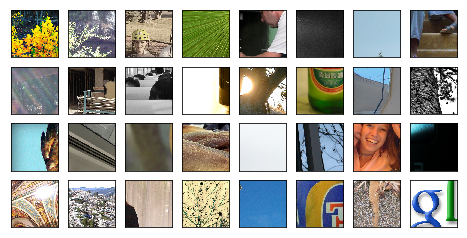

In [8]:
for X, _ in train_data:
    # from (B x c x H x W) to (Bx H x W x c)
    X = X.transpose((0,2,3,1)).clip(0,255)/255
    show_images(X, 4, 8)
    break

*Figure 3. Grid of images after transformations are performed*

<br>
Results are shown in Figure 3. Some of the images seem to contain logos, often truncated.
<br>

**Utility functions for training**

In this section, we will be defining utility functions to do the following

- Get the data for the batch being currently processed
- Evaluate the accuracy of the model
- Train the model
- Get the image - given an URL
- Predict the image's label, given the image

The first function, `_get_batch`, returns the data and label given the batch.

In [ ]:
def _get_batch(batch, ctx):
    """return data and label on ctx"""
    data, label = batch
    return (mx.gluon.utils.split_and_load(data, ctx),
            mx.gluon.utils.split_and_load(label, ctx),
            data.shape[0])

The function `evaluate_accuracy` returns the classification accuracy of the model. We have chosen a simple accuracy metric for the purpose of this article. In practice, the accuracy metric is chosen based on the application need. 

In [ ]:
def evaluate_accuracy(data_iterator, net, ctx):
    acc = mx.nd.array([0])
    n = 0.
    for batch in data_iterator:
        data, label, batch_size = _get_batch(batch, ctx)
        for X, y in zip(data, label):
            acc += mx.nd.sum(net(X).argmax(axis=1)==y).copyto(mx.cpu())
            n += y.size
        acc.wait_to_read()
    return acc.asscalar() / n

The next function we will define is the `train` function. This is by far the biggest function we will create in this article. 

Given an existing model, the train, test and validation datasets, the model is trained for the number of epochs specified. Our [previous article](https://www.oreilly.com/ideas/uncovering-hidden-patterns-through-machine-learning) contained a more detailed overview of how this function works.

Whenever the best accuracy on the validation dataset is found, the model is checkpointed. For each epoch, the train, validation and test accuracies are printed.

In [9]:
def train(net, ctx, train_data, val_data, test_data, batch_size, num_epochs, model_prefix, hybridize=False, learning_rate=0.01, wd=0.001):

    net.collect_params().reset_ctx(ctx)
    if hybridize == True:
        net.hybridize()
    loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': wd})
    
    best_epoch = -1
    best_acc = 0.0
    
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_loss, train_acc, n = 0.0, 0.0, 0.0
        start = time()
        for i, batch in enumerate(train_data):
            data, label, batch_size = _get_batch(batch, ctx)
            losses = []
            with mx.autograd.record():
                outputs = [net(X) for X in data]
                losses = [loss(yhat, y) for yhat, y in zip(outputs, label)]
            for l in losses:
                l.backward()
            train_loss += sum([l.sum().asscalar() for l in losses])
            trainer.step(batch_size)
            n += batch_size

        train_acc = evaluate_accuracy(train_data, net, ctx)
        val_acc = evaluate_accuracy(val_data, net, ctx)
        test_acc = evaluate_accuracy(test_data, net, ctx)
        print("Epoch %d. Loss: %.3f, Train acc %.2f, Val acc %.2f, Test acc %.2f, Time %.1f sec" % (
            epoch, train_loss/n, train_acc, val_acc, test_acc, time() - start
        ))
        if val_acc > best_acc:
            best_acc = val_acc
            if best_epoch!=-1:
                print('Deleting previous checkpoint...')
                os.remove(model_prefix+'-%d.params'%(best_epoch))
            best_epoch = epoch
            print('Best validation accuracy found. Checkpointing...')
            net.collect_params().save(model_prefix+'-%d.params'%(epoch))

The function `get_image` returns the image from a given URL. This is used for testing the model's accuracy

In [ ]:
def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    return fname

The final utility function we will define is `classify_logo`. Given the image and the model, the function returns the class of the image (in this case - the brand name) and its associated probability. 

In [10]:
def classify_logo(net, url):
    fname = get_image(url)
    with open(fname, 'rb') as f:
        img = mx.image.imdecode(f.read())
    data, _ = transform(img, -1, val_test_augs)
    data = data.expand_dims(axis=0)
    out = net(data.as_in_context(ctx[0]))
    out = mx.nd.SoftmaxActivation(out)
    pred = int(mx.nd.argmax(out, axis=1).asscalar())
    prob = out[0][pred].asscalar()
    label = train_imgs.synsets
    return 'With prob=%f, %s'%(prob, label[pred])

**Model**

Understanding the model architecture is quite important. In our [previous article](https://www.oreilly.com/ideas/uncovering-hidden-patterns-through-machine-learning), we built a multi-layer perceptron (MLP). The architecture is shown in Figure 4.

<img src="img/mlp1.png" style="width: 500px;"/>

*Figure 4: Multi-layer perceptron*

How would the input layer for a MLP model be? Our data is 224 * 224 pixels in size. 

The most common way to create the input layer from that is to flatten it - and create an input layer with 50,176 (224 * 224) neurons, ending up with a simple bit stream as shown in Figure 5.

<img src="img/flatten1.png" style="width: 300px;"/>

*Figure 5: Flattened input*

But image data has a lot of spatial information that is lost when such flattening is done. And the other challenge is the number of weights. If the first hidden layer has 30 hidden neurons, the number of parameters in the model will be 50,176 * 30 + 30 bias units. So this doesn't seem to be the right modeling approach for images. 

Let us now discuss the more appropriate architecture: a Convolutional Neural Network (CNN) for image classification.



**Convolutional Neural Network (CNN)**

CNNs are similar to MLP, in the sense that they are also made up neurons whose weights we learn. But the key difference is that the inputs are images, and the archicture allows us to exploit the properties of the image into the architecture. 

CNNs have convolutional layers. The term convolution is taken from image processing and it is described by Figure 6. This works on a small window, called *receptive field*, instead of all the inputs from the previous layer. This allows the model to learn localized features. 

Each layer moves a small matrix, called a kernel, over the part of the image fed to that layer. It adjusts each pixel to reflect the pixels around it, an operation that helps identify edges. Figure 6 shows an image on the left, a 3x3 kernel in the middle, and the results of applying the kernel to the top-left pixel on the right. We can also define multiple kernels, representing different feature maps.

<img src="img/cnn1.png" style="width: 700px;"/>

*Figure 6: Convolutional Layer*

In the example above, the input image was 5x5 and the kernel was 3x3. The computation was an element-wise multplication between the two matrices. The output was 5x5. How is that?

To understand this, we need to understand two parameters at the convolution layer: *stride* and *padding*

Stride controls how the kernel(filter) moves along the image.

Figure 7 illustrates the movement of the kernel from the first pixel to the second.

<img src="img/cnn2.png" style="width: 500px;"/>

*Figure 7: Kernel movement*

In the above figure, the stride is 1.

When a 5x5 image is convolved with a 3x3 kernel, we will be getting a 3x3 image. Consider the case where we add a zero padding around the image. The 5x5 image is now surrounded with 0. This is illustrated in Figure 8.

<img src="img/padding1.png" style="width: 300px;"/>

*Figure 8: Zero padding*

This, when multipled by a 3x3 kernel, will result in a 5x5 output. 

So, for the computation shown in Figure 6, it had a stride of 1 and padding of size 1. 

CNN works with drastically fewer weights than the corresponding MLP. Say we use 30 kernels, each with 3x3 elements. Each kernel has 3x3 = 9 + 1 (for bias) parameters. This leads to 10 weights per kernel, 300 for 30 kernels. Contraste this against the 150,000 weights for the MLP in the previous section.

The next layer is typically a sub-sampling layer. Once we have identified the features, this sub-sampling layer simplifies the information. A common method is max-pooling, which outputs the greatest value from each localized region of the output from the convolutional layer (Figure 9). It reduces the output size, while preserving the maximum activation in every localized region.

<img src="img/cnn3.png" style="width: 500px;"/>

*Figure 9: Max pooling*

You can see that it reduces the output size, while preserving the maximum activation in every localized region. 

A good resource for more information on CNNs is the online book, [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html). Another good resource is Stanford University's [CNN course](http://cs231n.github.io/convolutional-networks/)

Now that we have learned the basics of what CNN is, let’s go and implement it for our problem using `gluon`.



The first step is to define the architecture. 

In [11]:
cnn_net = mx.gluon.nn.Sequential()
with cnn_net.name_scope():
    #  First convolutional layer
    cnn_net.add(mx.gluon.nn.Conv2D(channels=96, kernel_size=11, strides=(4,4), activation='relu'))
    cnn_net.add(mx.gluon.nn.MaxPool2D(pool_size=3, strides=2))
    #  Second convolutional layer
    cnn_net.add(mx.gluon.nn.Conv2D(channels=192, kernel_size=5, activation='relu'))
    cnn_net.add(mx.gluon.nn.MaxPool2D(pool_size=3, strides=(2,2)))
    # Flatten and apply fullly connected layers
    cnn_net.add(mx.gluon.nn.Flatten())
    cnn_net.add(mx.gluon.nn.Dense(4096, activation="relu"))
    cnn_net.add(mx.gluon.nn.Dense(num_classes))

Now that the model architecture is defined, let's initialize the weights of the network. We will use the [Xavier initalizer](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization).

In [ ]:
cnn_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

Once the weights are initialized, we can train the model. We will call the same `train` function defined earlier and pass the required parameters for the function.

In [12]:
train(cnn_net, ctx, train_data, val_data, test_data, batch_size, num_epochs,model_prefix='cnn')

Epoch 0. Loss: 53.771, Train acc 0.77, Val acc 0.58, Test acc 0.72, Time 224.9 sec
Best validation accuracy found. Checkpointing...
Epoch 1. Loss: 3.417, Train acc 0.80, Val acc 0.60, Test acc 0.73, Time 222.7 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 2. Loss: 3.333, Train acc 0.81, Val acc 0.60, Test acc 0.74, Time 222.5 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 3. Loss: 3.227, Train acc 0.82, Val acc 0.61, Test acc 0.75, Time 222.4 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 4. Loss: 3.079, Train acc 0.82, Val acc 0.61, Test acc 0.75, Time 222.0 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 5. Loss: 2.850, Train acc 0.82, Val acc 0.61, Test acc 0.76, Time 222.7 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 6. Loss: 2.488, Train acc 0.82, Val acc 0.61, T

We asked the model to run for 20 epochs. Typically, we train for many epochs and pick the model at the epoch where the validation accuracy is the highest. Here, after 20 epochs, we can see from the log just shown that the model's best validation accuracy was in epoch 5. After that, the model doesn't seem to have learned much. Probably, the network was saturated and learning took place very slowly. We’ll try out a better approach in the next section, but first we’ll see how our current model performs.

Collect the parameters of the epoch that had the best validation accuracy and assign it as our model parameters.

In [13]:
cnn_net.collect_params().load('cnn-%d.params'%(5),ctx)

Let's now check how the model performs on new data. We’ll get an easy-to-recognize images from the Web (Figure 10) and see the model's accuracy.

'With prob=0.081522, no-logo'

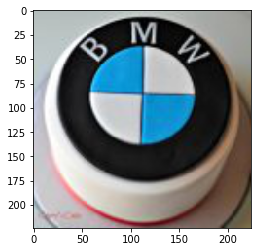

In [14]:
img_url = "http://sophieswift.com/wp-content/uploads/2017/09/pleasing-ideas-bmw-cake-and-satisfying-some-bmw-themed-cakes-crustncakes-delicious-cakes-128x128.jpg"
classify_logo(cnn_net, img_url)

*Figure 10. BMW logo*

The model's prediction has been terrible. It predicts the image to have no logo with probability of 8%. The prediction is wrong and the probability is quite weak.

Let's try one more test image (Figure 11) to see whether accuracy is any better.

'With prob=0.075301, no-logo'

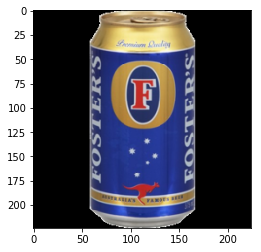

In [15]:
img_url = "https://dtgxwmigmg3gc.cloudfront.net/files/59cdcd6f52ba0b36b5024500-icon-256x256.png"
classify_logo(cnn_net, img_url)

*Figure 11. Foster’s logo*

Yet again, the model's prediction is wrong and the probability is quite weak.

We don't have much data and the model training has saturated, as just seen. We can experiment with more model architectures, but we won’t overcome the problems of small datasets and trainable parameters much greater than the number of training images. So, how do we get around this problem? Can't deep learning be used if there isn't much data?

The answer to that is *transfer learning*, discussed next.

**Transfer Learning**

Consider this analogy: You want to pick up a new foreign language. How does the learning happen? 

You would take a conversation - say for example:
Instructor: How are you doing?
You: I am good. How about you?

And you will try to learn the equivalent of this in the new language.

Because of your proficiency in English, you don't start learning a new language from scratch(even if it seems that you do). You already have the mental map of a language and you try to find the corresponding words in the new language. Therefore, in the new language, while your vocabulary might still be limited, you will still be able to converse because of your knowledge of the structure of conversations in English.

Transfer learning works the same way. Highly accurate models are built on datasets where a lot of data is available. A common dataset that you will come across is the [ImageNet](http://www.image-net.org/) data. It has more than a million images. Researchers from around the world have built many different state-of-art models using this data. The resulting model - comprised of model architecture and weights, is freely available on the internet. 

And starting from that pre-trained model, we will train the model for our problem. In fact, this is quite the norm. Almost invariably, the first model one would build for a computer vision problem would employ a pre-trained model.

In many cases, like our example, this might be all one can do - if restricted for data. 

The typical practice is to keep many of the early layers fixed, and train only the last layers. If data is quite limited, only the classifier layer is re-trained. If data is moderately abundant, the last few layers are re-trained.

Why does it work? Because a Convolutional Neural Network learns higher level representation at each successive layer, the learning it has done at many of the early layers is held in common by all image classification problems.

Let us now use a pre-trained model for logo detection.

`MXNet` has a model zoo with a number of pre-trained models.

We will use a popular pre-trained model called resnet. The [paper](https://arxiv.org/abs/1512.03385) provides a lot of details on the model structure. A simpler explanation can be found in [this](https://blog.waya.ai/deep-residual-learning-9610bb62c355) article.

Let's first download the pre-trained model

In [16]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained=True)

Since our dataset is small, we will re-train onluy the output layer. We randomly initialize the weights for the output layer

In [17]:
finetune_net = models.resnet18_v2(classes=num_classes)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(mx.init.Xavier(magnitude=2.24))

We now call the same train function as before.

In [18]:
train(finetune_net, ctx, train_data, val_data, test_data, batch_size, num_epochs,model_prefix='ft',hybridize = True)

Epoch 0. Loss: 1.107, Train acc 0.83, Val acc 0.62, Test acc 0.76, Time 246.1 sec
Best validation accuracy found. Checkpointing...
Epoch 1. Loss: 0.811, Train acc 0.85, Val acc 0.62, Test acc 0.77, Time 243.7 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 2. Loss: 0.722, Train acc 0.86, Val acc 0.64, Test acc 0.78, Time 245.3 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 3. Loss: 0.660, Train acc 0.87, Val acc 0.66, Test acc 0.79, Time 243.4 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 4. Loss: 0.541, Train acc 0.88, Val acc 0.67, Test acc 0.80, Time 244.5 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 5. Loss: 0.528, Train acc 0.89, Val acc 0.68, Test acc 0.80, Time 243.4 sec
Deleting previous checkpoint...
Best validation accuracy found. Checkpointing...
Epoch 6. Loss: 0.490, Train acc 0.90, Val acc 0.68, Te

The model starts right away with a higher accuracy. Typically, when data is less, we train only for a few epochs and pick the model at the epoch where the validation accuracy is the highest.

Here, epoch 16 has the best validation accuracy. Since the training data is limited, and the model kept on training, it has started to overfit. We can see that after epoch 16, while training accuracy is increasing, validation accuracy has begun to decrease.

Let's collect the parameters from the corresponding checkpoint of the 16th epoch and use it as the final model. 

In [19]:
# The model's parameters are now set to the values at the 16th epoch
finetune_net.collect_params().load('ft-%d.params'%(16),ctx)

**Evaluating the predictions**

For the same images that we used earlier to evaluate the predictions, let us see the prediction of the new model.


'With prob=0.983476, bmw'

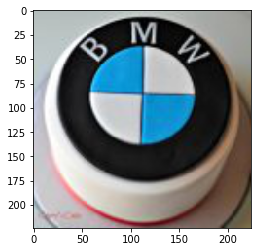

In [20]:
img_url = "http://sophieswift.com/wp-content/uploads/2017/09/pleasing-ideas-bmw-cake-and-satisfying-some-bmw-themed-cakes-crustncakes-delicious-cakes-128x128.jpg"
classify_logo(finetune_net, img_url)

We can see that the model is able to predict BMW with 98% probability.

Let us now try the other image we tested earlier.

'With prob=0.498218, fosters'

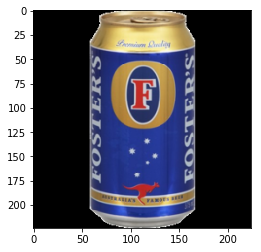

In [21]:
img_url = "https://dtgxwmigmg3gc.cloudfront.net/files/59cdcd6f52ba0b36b5024500-icon-256x256.png"
classify_logo(finetune_net, img_url)

While the prediction probability isn't good, a tad lower than 50%, Foster still gets the highest probability amongst all the logos. 

**Improving the model**

To improve the model, we need to fix the way we constructed the training dataset. Each individual logo had 10 training points. But as part of distributing the no-logo from validation to training, we moved 1500 images to training as no-logo. This introduces a significant dataset bias. This is not a good practice. So, how to fix this? The following are some options:

- Weight the cross-entroy loss
- Don't include the no-logo images in training dataset. Build a model that predicts low class probabilities to all logos if it doesn't exist in test/validation images. 

But remember that even with transfer learning and data augmentation, we only have 320 images and it is quite low to build highly accurate deep learning models. 


**Conclusion**

In this article, we learned how to build image recognition models using `MXNet`.  `Gluon` is ideal for rapid prototyping. Moving from prototyping to production is also quite easy with [hybridization](https://mxnet.incubator.apache.org/tutorials/gluon/hybrid.html) and symbol export. With a host of pre-trained models available on `MXNet`, we were able to get very good models for logo detection in pretty quick time. A very good resource for learning more about the underying theory is the Stanford's [CS231n course](http://cs231n.stanford.edu/). 